### Library

In [2]:
from datetime import datetime, timedelta
import oandapy
import pandas as pd
import time
import matplotlib.pyplot as plt
import mpl_finance as mpf
from matplotlib.dates import date2num
import numpy as np
from config import token

### Oandaのインスタンス化

In [3]:
access_token = token
oanda = oandapy.API(environment="practice", access_token=access_token)

### 過去データの取得

In [417]:
#取得したい日付
end = datetime(2018, 8, 1, 0, 0)
start = end - timedelta(days = 4999)

end_day =  '{0}-{1:02d}-{2:02d}-{3:02d}:{4:02d}:{5:02d}'.format(end.year, end.month, end.day, end.hour, end.minute, end.second)
start_day =  '{0}-{1:02d}-{2:02d}-{3:02d}:{4:02d}:{5:02d}'.format(start.year, start.month, start.day, start.hour, start.minute, start.second)

res = oanda.get_history(instrument="USD_JPY",granularity="D",start = start_day, end = end_day)

In [418]:
df = pd.DataFrame(res['candles'])
df = df.drop(['complete'], axis = 1)

df['time'] = df['time'].str[:-8]
df['time'] = df['time'].str.replace('T',' ')
times = [datetime.strptime(v, '%Y-%m-%d %H:%M:%S') for v in df['time']]
df['time'] = times
df = df.set_index('time',drop = True)

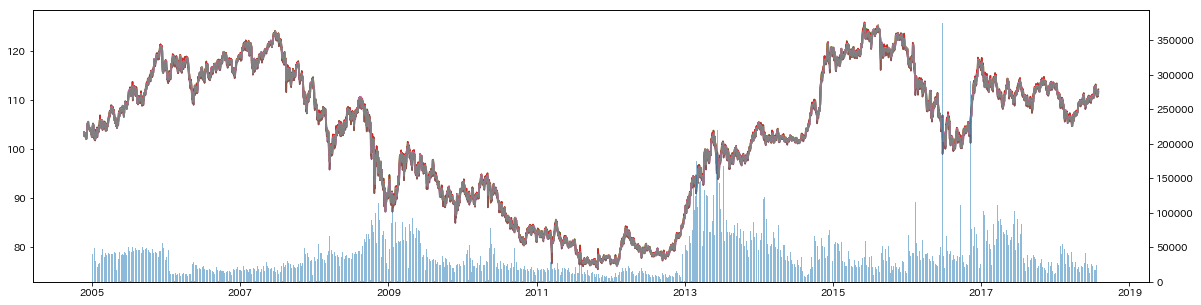

In [338]:
fig = plt.figure(figsize = (20,5))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(df.index, df.iloc[:,:8])
ax2 = ax1.twinx()  # 2つのプロットを関連付ける
ax2.bar(df.index, df['volume'], width = 1, alpha = 0.5)
plt.show()

### 過去データの分析

In [734]:
#移動平均の計算
rolling_day = 20
roll_mean = df.rolling(rolling_day).mean()

In [735]:
#移動平均の前日との差の計算
today = roll_mean.iloc[1:,:].reset_index(drop = True)
pre_day = roll_mean.iloc[:-1,:].reset_index(drop = True)
delta = today - pre_day
delta['date'] = roll_mean.iloc[1:,:].index
delta = delta.set_index('date', drop = True)

df1 = df.iloc[1:,:]
roll_mean1 = roll_mean.iloc[1:,:]
df1['roll_mean_closeAsk'] = roll_mean1['closeAsk']
df1['roll_mean_closeBid'] = roll_mean1['closeBid']
df1['roll_mean_highAsk'] = roll_mean1['highAsk']
df1['roll_mean_highBid'] = roll_mean1['highBid']
df1['roll_mean_lowAsk'] = roll_mean1['lowAsk']
df1['roll_mean_lowBid'] = roll_mean1['lowBid']
df1['roll_mean_openAsk'] = roll_mean1['openAsk']
df1['roll_mean_openBid'] = roll_mean1['openBid']
df1['delta_closeAsk'] = delta['closeAsk']
df2 = df1.iloc[19:,:]

/Users/toshio/py3env/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/toshio/py3env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/toshio/py3env/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [736]:
# 閾値を設定してlong or shortの条件を得る
# 【条件1】日足全体が移動平均線の上にある
# 【条件2】日足の移動平均の変化が閾値を超える

threshold = 0.05
cond_buy = (df2['lowAsk'] > df2['roll_mean_closeAsk']) & (df2['delta_closeAsk'] > threshold)
cond_sell = (df2['highAsk'] < df2['roll_mean_closeAsk']) & (df2['delta_closeAsk'] < -1*threshold)
df2['cond_buy'] = cond_buy
df2['cond_sell'] = cond_sell

/Users/toshio/py3env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/toshio/py3env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [737]:
# long, shortの条件で売買したときの利益の計算
long = []
short = []
gets = []
for i in range(df2.shape[0]):
    if df2['cond_buy'][i]:
        print(df2.index[i], 'Buy@{}'.format(df2['openAsk'][i+1]))
        long.append(df2['openAsk'][i+1])
    elif df2['cond_sell'][i]:
        print(df2.index[i], 'Sell@{}'.format(df2['openBid'][i+1]))
        short.append(df2['openBid'][i+1])
    else:
        if len(long) != 0:
            get = len(long) * df2['openBid'][i+1] - sum(long)
            gets.append(get)
            long = []
            print(df2.index[i], 'SellBack@{}'.format(df2['openBid'][i+1]))
            print('long_get = ', get)            
        elif len(short) != 0:
            get =  sum(short) - len(short) * df2['openAsk'][i+1]
            gets.append(get)
            short = []
            print(df2.index[i], 'BuyBack@{}'.format(df2['openAsk'][i+1]))
            print('short_get = ', get)
        else:
            print(df2.index[i], 'zero_position')
print('総利益は{}'.format(sum(gets)))

2004-12-15 22:00:00 Buy@104.31
2004-12-16 22:00:00 Buy@103.98
2004-12-18 22:00:00 Buy@104.13
2004-12-19 22:00:00 Buy@104.36
2004-12-20 22:00:00 Buy@104.25
2004-12-21 22:00:00 Buy@103.59
2004-12-22 22:00:00 SellBack@103.64
long_get =  -2.7799999999999727
2004-12-23 22:00:00 zero_position
2004-12-25 22:00:00 zero_position
2004-12-26 22:00:00 zero_position
2004-12-27 22:00:00 zero_position
2004-12-28 22:00:00 zero_position
2004-12-29 22:00:00 zero_position
2004-12-30 22:00:00 Sell@102.49
2005-01-01 22:00:00 Sell@102.66
2005-01-02 22:00:00 Sell@102.78
2005-01-03 22:00:00 BuyBack@104.57
short_get =  -5.78000000000003
2005-01-04 22:00:00 zero_position
2005-01-05 22:00:00 zero_position
2005-01-06 22:00:00 zero_position
2005-01-08 22:00:00 zero_position
2005-01-09 22:00:00 zero_position
2005-01-10 22:00:00 zero_position
2005-01-11 22:00:00 Sell@102.427
2005-01-12 22:00:00 Sell@102.37
2005-01-13 22:00:00 Sell@101.98
2005-01-14 22:00:00 Sell@101.93
2005-01-15 22:00:00 Sell@101.93
2005-01-16 22:0

2006-10-20 21:00:00 zero_position
2006-10-21 21:00:00 zero_position
2006-10-22 21:00:00 zero_position
2006-10-23 21:00:00 Buy@119.366
2006-10-24 21:00:00 SellBack@119.105
long_get =  -0.2609999999999957
2006-10-25 21:00:00 zero_position
2006-10-26 21:00:00 Sell@117.49
2006-10-28 21:00:00 Sell@117.415
2006-10-29 22:00:00 Sell@117.477
2006-10-30 22:00:00 Sell@116.964
2006-10-31 22:00:00 Sell@117.03
2006-11-01 22:00:00 Sell@117.123
2006-11-02 22:00:00 Sell@117.99
2006-11-04 22:00:00 Sell@118.03
2006-11-05 22:00:00 BuyBack@118.323
short_get =  -7.064999999999941
2006-11-06 22:00:00 zero_position
2006-11-07 22:00:00 zero_position
2006-11-08 22:00:00 zero_position
2006-11-09 22:00:00 zero_position
2006-11-11 22:00:00 Sell@117.48
2006-11-12 22:00:00 BuyBack@118.187
short_get =  -0.7069999999999936
2006-11-13 22:00:00 zero_position
2006-11-14 22:00:00 zero_position
2006-11-15 22:00:00 zero_position
2006-11-16 22:00:00 zero_position
2006-11-18 22:00:00 zero_position
2006-11-19 22:00:00 zero_pos

2008-03-16 21:00:00 Sell@97.32
2008-03-17 21:00:00 Sell@99.843
2008-03-18 21:00:00 Sell@99.026
2008-03-19 21:00:00 Sell@99.488
2008-03-20 21:00:00 Sell@99.529
2008-03-21 21:00:00 Sell@99.43
2008-03-22 21:00:00 Sell@99.37
2008-03-23 21:00:00 Sell@100.73
2008-03-24 21:00:00 BuyBack@99.994
short_get =  31.630999999999858
2008-03-25 21:00:00 Sell@99.203
2008-03-26 21:00:00 Sell@99.66
2008-03-27 21:00:00 BuyBack@99.212
short_get =  0.43899999999999295
2008-03-29 21:00:00 Sell@99.092
2008-03-30 21:00:00 BuyBack@99.702
short_get =  -0.6099999999999994
2008-03-31 21:00:00 zero_position
2008-04-01 21:00:00 zero_position
2008-04-02 21:00:00 zero_position
2008-04-03 21:00:00 zero_position
2008-04-05 21:00:00 Buy@101.575
2008-04-06 21:00:00 Buy@102.414
2008-04-07 21:00:00 Buy@102.68
2008-04-08 21:00:00 Buy@101.81
2008-04-09 21:00:00 SellBack@101.925
long_get =  -0.7789999999999964
2008-04-10 21:00:00 zero_position
2008-04-12 21:00:00 Buy@101.465
2008-04-13 21:00:00 SellBack@101.089
long_get =  -0.

2009-07-22 21:00:00 BuyBack@94.951
short_get =  -2.519999999999982
2009-07-23 21:00:00 zero_position
2009-07-25 21:00:00 zero_position
2009-07-26 21:00:00 zero_position
2009-07-27 21:00:00 zero_position
2009-07-28 21:00:00 zero_position
2009-07-29 21:00:00 zero_position
2009-07-30 21:00:00 Buy@94.831
2009-08-01 21:00:00 Buy@94.805
2009-08-02 21:00:00 Buy@95.269
2009-08-03 21:00:00 SellBack@95.233
long_get =  0.7939999999999827
2009-08-04 21:00:00 Buy@94.987
2009-08-05 21:00:00 Buy@95.47
2009-08-06 21:00:00 Buy@97.615
2009-08-07 21:00:00 Buy@97.615
2009-08-08 21:00:00 Buy@97.702
2009-08-09 21:00:00 Buy@97.166
2009-08-10 21:00:00 Buy@95.997
2009-08-11 21:00:00 SellBack@96.038
long_get =  -4.286000000000058
2009-08-12 21:00:00 zero_position
2009-08-13 21:00:00 zero_position
2009-08-15 21:00:00 zero_position
2009-08-16 21:00:00 zero_position
2009-08-17 21:00:00 zero_position
2009-08-18 21:00:00 zero_position
2009-08-19 21:00:00 zero_position
2009-08-20 21:00:00 Sell@94.35
2009-08-22 21:00:

2011-01-09 22:00:00 zero_position
2011-01-10 22:00:00 zero_position
2011-01-11 22:00:00 zero_position
2011-01-12 22:00:00 zero_position
2011-01-13 22:00:00 zero_position
2011-01-14 22:00:00 zero_position
2011-01-15 22:00:00 zero_position
2011-01-16 22:00:00 zero_position
2011-01-17 22:00:00 zero_position
2011-01-18 22:00:00 zero_position
2011-01-19 22:00:00 zero_position
2011-01-20 22:00:00 zero_position
2011-01-21 22:00:00 zero_position
2011-01-22 22:00:00 zero_position
2011-01-23 22:00:00 zero_position
2011-01-24 22:00:00 zero_position
2011-01-25 22:00:00 Sell@82.162
2011-01-26 22:00:00 BuyBack@82.95
short_get =  -0.7879999999999967
2011-01-27 22:00:00 zero_position
2011-01-28 22:00:00 Sell@82.075
2011-01-29 22:00:00 BuyBack@82.029
short_get =  0.04600000000000648
2011-01-30 22:00:00 Sell@82.03
2011-01-31 22:00:00 Sell@81.346
2011-02-01 22:00:00 Sell@81.545
2011-02-02 22:00:00 Sell@81.617
2011-02-03 22:00:00 BuyBack@82.226
short_get =  -2.3659999999999854
2011-02-04 22:00:00 zero_pos

2012-06-19 21:00:00 zero_position
2012-06-20 21:00:00 zero_position
2012-06-21 21:00:00 Buy@80.479
2012-06-22 21:00:00 Buy@80.52
2012-06-23 21:00:00 Buy@80.461
2012-06-24 21:00:00 SellBack@79.654
long_get =  -2.4979999999999905
2012-06-25 21:00:00 zero_position
2012-06-26 21:00:00 zero_position
2012-06-27 21:00:00 zero_position
2012-06-28 21:00:00 zero_position
2012-06-30 21:00:00 zero_position
2012-07-01 21:00:00 zero_position
2012-07-02 21:00:00 zero_position
2012-07-03 21:00:00 zero_position
2012-07-04 21:00:00 zero_position
2012-07-05 21:00:00 zero_position
2012-07-06 21:00:00 zero_position
2012-07-07 21:00:00 zero_position
2012-07-08 21:00:00 zero_position
2012-07-09 21:00:00 zero_position
2012-07-10 21:00:00 zero_position
2012-07-11 21:00:00 zero_position
2012-07-12 21:00:00 Sell@79.164
2012-07-13 21:00:00 Sell@79.154
2012-07-14 21:00:00 Sell@79.259
2012-07-15 21:00:00 BuyBack@78.871
short_get =  0.9639999999999986
2012-07-16 21:00:00 zero_position
2012-07-17 21:00:00 zero_positi

2014-07-17 21:00:00 zero_position
2014-07-20 21:00:00 zero_position
2014-07-21 21:00:00 zero_position
2014-07-22 21:00:00 zero_position
2014-07-23 21:00:00 zero_position
2014-07-24 21:00:00 zero_position
2014-07-27 21:00:00 zero_position
2014-07-28 21:00:00 zero_position
2014-07-29 21:00:00 Buy@102.836
2014-07-30 21:00:00 SellBack@102.774
long_get =  -0.06199999999999761
2014-07-31 21:00:00 zero_position
2014-08-03 21:00:00 zero_position
2014-08-04 21:00:00 Buy@102.603
2014-08-05 21:00:00 SellBack@102.096
long_get =  -0.5069999999999908
2014-08-06 21:00:00 zero_position
2014-08-07 21:00:00 zero_position
2014-08-10 21:00:00 zero_position
2014-08-11 21:00:00 zero_position
2014-08-12 21:00:00 zero_position
2014-08-13 21:00:00 Buy@102.46
2014-08-14 21:00:00 SellBack@102.311
long_get =  -0.1489999999999867
2014-08-17 21:00:00 Buy@102.581
2014-08-18 21:00:00 Buy@102.957
2014-08-19 21:00:00 Buy@103.8
2014-08-20 21:00:00 Buy@103.856
2014-08-21 21:00:00 Buy@104.312
2014-08-24 21:00:00 Buy@104.0

2016-06-22 21:00:00 Sell@106.099
2016-06-23 21:00:00 BuyBack@101.577
short_get =  53.837999999999965
2016-06-26 21:00:00 Sell@101.915
2016-06-27 21:00:00 Sell@102.727
2016-06-28 21:00:00 Sell@102.8
2016-06-29 21:00:00 Sell@103.128
2016-06-30 21:00:00 Sell@102.593
2016-07-03 21:00:00 Sell@102.505
2016-07-04 21:00:00 Sell@101.669
2016-07-05 21:00:00 Sell@101.298
2016-07-06 21:00:00 Sell@100.696
2016-07-07 21:00:00 Sell@100.596
2016-07-10 21:00:00 Sell@102.77
2016-07-11 21:00:00 BuyBack@104.741
short_get =  -29.45399999999995
2016-07-12 21:00:00 zero_position
2016-07-13 21:00:00 Buy@105.364
2016-07-14 21:00:00 SellBack@105.316
long_get =  -0.04800000000000182
2016-07-17 21:00:00 Buy@106.188
2016-07-18 21:00:00 Buy@106.14
2016-07-19 21:00:00 Buy@106.943
2016-07-20 21:00:00 SellBack@105.825
long_get =  -1.7959999999999923
2016-07-21 21:00:00 Buy@106.188
2016-07-24 21:00:00 Buy@105.843
2016-07-25 21:00:00 Buy@104.712
2016-07-26 21:00:00 Buy@105.428
2016-07-27 21:00:00 Buy@105.331
2016-07-28 

short_get =  -2.086999999999989
2018-02-04 22:00:00 zero_position
2018-02-05 22:00:00 Sell@109.513
2018-02-06 22:00:00 Sell@109.322
2018-02-07 22:00:00 Sell@108.708
2018-02-08 22:00:00 Sell@108.838
2018-02-11 22:00:00 Sell@108.614
2018-02-12 22:00:00 Sell@107.772
2018-02-13 22:00:00 Sell@106.93
2018-02-14 22:00:00 Sell@106.093
2018-02-15 22:00:00 Sell@106.294
2018-02-18 22:00:00 Sell@106.566
2018-02-19 22:00:00 Sell@107.305
2018-02-20 22:00:00 Sell@107.738
2018-02-21 22:00:00 Sell@106.727
2018-02-22 22:00:00 Sell@107.173
2018-02-25 22:00:00 Sell@106.901
2018-02-26 22:00:00 Sell@107.31
2018-02-27 22:00:00 Sell@106.644
2018-02-28 22:00:00 Sell@106.198
2018-03-01 22:00:00 Sell@105.412
2018-03-04 22:00:00 Sell@106.173
2018-03-05 22:00:00 Sell@106.109
2018-03-06 22:00:00 Sell@106.05
2018-03-07 22:00:00 Sell@106.168
2018-03-08 22:00:00 BuyBack@106.692
short_get =  10.64200000000119
2018-03-11 21:00:00 zero_position
2018-03-12 21:00:00 zero_position
2018-03-13 21:00:00 zero_position
2018-03-1

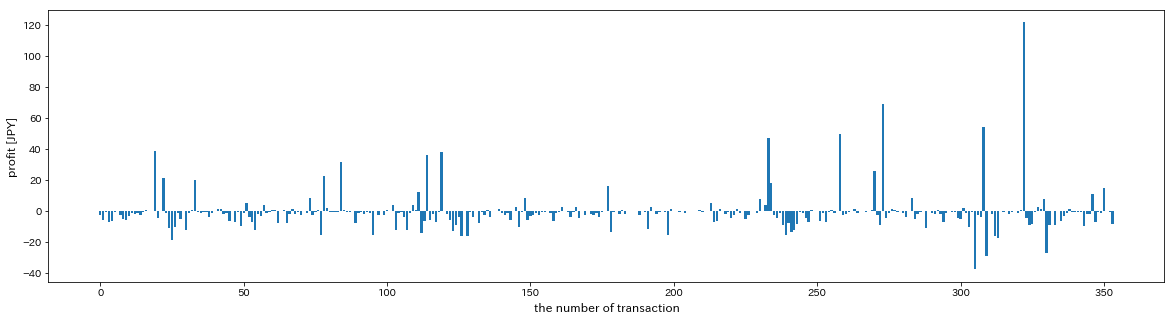

In [738]:
plt.figure(figsize = (20,5))
plt.bar(np.arange(len(gets)), gets)
plt.xlabel('the number of transaction', fontsize = 12)
plt.ylabel('profit [JPY]',fontsize = 12)
plt.show()

### グラフの描画

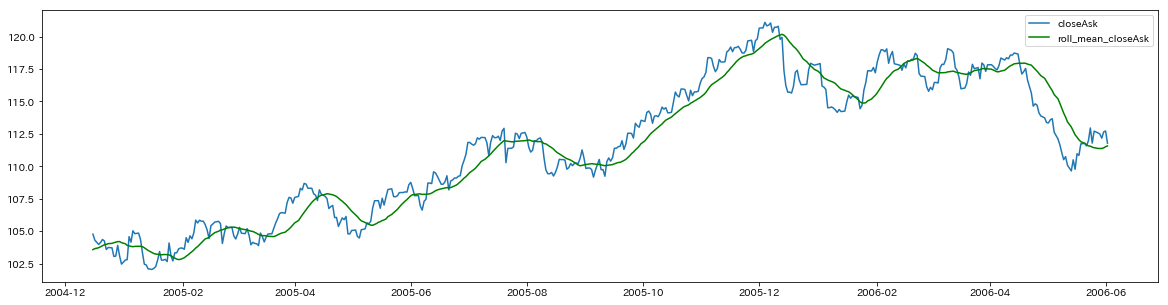

In [739]:
df3 = df2.iloc[:500,:]

fig = plt.figure(figsize = (20,5))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(df3.index, df3['closeAsk'], label = 'closeAsk')
ax1.plot(df3.index, df3['roll_mean_closeAsk'], c = 'g',label = 'roll_mean_closeAsk')
# ax1.axvspan('2004-12-31', '2005-12-31', facecolor='r', alpha=0.5)
# ax2 = ax1.twinx()  # 2つのプロットを関連付ける
# ax2.bar(plot_data.index, plot_data['volume'], width = 1, alpha = 0.5)
# ax2.plot(df3.index, df3['roll_mean_closeAsk'], c = 'g')
plt.legend()
plt.show()

### 取引

In [6]:
# sample account_id
# account_id = ****

# set the trade to expire after one day
trade_expire = datetime.utcnow() + timedelta(days=1)
trade_expire = trade_expire.isoformat("T") + "Z"

response = oanda.create_order(account_id,
    instrument='USD_JPY',
    units=100,
    side='buy',
    type='limit',
    price=1.10,
    expiry=trade_expire
)

### 現時刻情報の取得

In [224]:
#1秒おきに現時刻情報を取得
interval = 1
asking_price = []
bid_price = []
response = oanda.get_prices(instruments='USD_JPY')
i = 0
while i <10:
    prices = response.get("prices")
    asking_price.append(prices[0].get("ask"))
    bid_price.append(prices[0].get("bid"))
    time.sleep(interval)
    i = i + 1